In [1]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import normalize
from matplotlib.offsetbox import AnchoredText
import random

In [2]:
np.random.seed(0)
X = np.linspace(-5,5,num=20)
X0 = X*np.random.rand(len(X))+15 # Create data cluster 1
X1 = X*np.random.rand(len(X))-15 # Create data cluster 2
X2 = X*np.random.rand(len(X)) # Create data cluster 3
XX = np.stack((X0,X1,X2)).flatten() # Combine the clusters to get the random 

In [139]:
def plot_gaussians_vs_data(x, gaussians, mus, sigmas, colors = False, color_values = None, _step = "Initialization", i = 0, histo = True, points = True):
    
    _max = 20 #np.amax(x) + 20
    _min = -20 #np.amin(x) - 20
    
    xi = [xi[0]for xi in x]
    z = np.zeros(len(x)) 
    
    if colors:
        x_colors = np.array([[0, xi[1]*0.75, xi[0]*0.75] for xi in color_values])
    else:
        x_colors = np.array([[0,0,0] for xi in x])
        
    plt.xticks([])
    plt.yticks([])

    #x_colors = np.array([[random.randint(0,255),random.randint(0,255),random.randint(0,255)] for xi in x])
    
    if histo:
        plt.hist(x, bins = 30, density = True, color = 'magenta', alpha = 0.5)
        
    if points:
        plt.scatter(xi, z, c=x_colors)
        
    #colors = ['skyblue', 'steelblue', 'cornflowerblue']
    colors = ['steelblue', 'mediumseagreen', 'cornflowerblue']
    
    maxcoords = 0
    for k in range(len(gaussians)):
        gaussian = gaussians[k]
        mu = mus[k]
        sigma = sigmas[k]
        steps = int((_max - _min) / 0.01)
        x = np.linspace(_min, _max, steps, endpoint=False)
        coords = gaussian.pdf(x)
        plt.plot(x, coords, color=colors[k])
        plt.vlines(ymin = 0, ymax = (max(coords)), x=mu, color='black', ls='--', alpha = 0.2)
        if max(coords) > maxcoords:
            maxcoords = max(coords)
    
    style = dict(size=10, color='black')
    bbox_style = {
            'facecolor': 'white',
            'edgecolor': 'lightgrey',
            'boxstyle': 'square', # here i would like to add some 
            'pad': 0.4}
    
    plt.text(12.2, maxcoords*0.87, f"{_step}\nIteration: {i}",bbox = bbox_style, **style)
        
    plt.show()

In [123]:
def EM_GMM_1D(X, n_clusters=3, epsilon=0.001, dim = 1, seed = 0, max_iter = 100, histo = True, points = False):
    
    np.random.seed(seed)
    
    # --- Step 1: ---
    
    # Fix 2 <= c <= len(X) and fix any epsilon (stop condition).

    c = n_clusters
    eps = epsilon
    max_X = np.amax(X)
    min_X = np.amin(X)
    n = X.shape[0]
    z_hat_ki = np.zeros((n, c))
    
    #alpha = np.random.dirichlet(np.ones(n_clusters))
    #mus = np.random.uniform(min_X, max_X, n_clusters)
    #sigmas = np.random.uniform(0, max_X/2, n_clusters)
    
    #tutorial init
    #alpha = [1/3,1/3,1/3]
    #mus = [-8,8,5]
    #sigmas = [5,3,1]
    
    #tutorial init
    alpha = [95/100,5/100]
    mus = [-10,1]
    sigmas = [3,3]
    
    try:
        X.shape[1]
    except:
        X = X.reshape(n, 1)
    
    # Give initials z_hat = (z_hat_1, z_hat_2, ... z_hat_c)
    
    z_hat = [norm(loc=mus[k], scale = sigmas[k]) for k in range(c)]
    
    for s in range(max_iter + 1):  
        
        #Initialize
        if s == 0:
            plot_gaussians_vs_data(X, z_hat, mus, sigmas, histo = histo, points = points, i = s)
        else:
            plot_gaussians_vs_data(X, [norm(loc=mus[k], scale = sigma[k]) for k in range(c)], mus, sigma, histo = histo, points = points, i = s)
        
        #plot_gaussians_vs_data(X, [norm(loc=mus[k], scale = sigma[k]) for k in range(c)], mus, sigma, colors = True, color_values=z_hat_ki, histo = histo, points = points)
        
    # --- Step 2: ---

        #equation 4
        for k, z, p in zip(range(c), z_hat, alpha):
                    z_hat_ki[:,k] = (p * z.pdf(X)).reshape(n,)

        #z_hat_ki = normalize(z_hat_ki, axis=1, norm='l1'), does do the same thing?
        
        for i in range(n):
                z_hat_ki[i] = z_hat_ki[i]/(np.sum(alpha)*np.sum(z_hat_ki ,axis=1)[i])
        
        
        #Expectation
        if s == 0:
            plot_gaussians_vs_data(X, z_hat, mus, sigmas, colors = True, color_values=z_hat_ki, histo = histo, points = points, i = s, _step = "Expectation")
        else:
            plot_gaussians_vs_data(X, [norm(loc=mus[k], scale = sigma[k]) for k in range(c)], mus, sigma, colors = True, color_values=z_hat_ki, histo = histo, points = points,  i = s, _step = "Expectation")
        
        
        
        #equation 6
        alpha = np.sum(z_hat_ki, axis = 0)/n
        
        #equation 8
        mus = np.sum(z_hat_ki * X.reshape(n,1), axis = 0) / np.sum(z_hat_ki, axis = 0)
        
        # --- Step 3: ---

        #equation 9
        centered_X = X - mus
        sigma = np.zeros(c)

        for k in range(c):
            c_X = X - mus[k]
            sigma[k] = np.dot((z_hat_ki[:,k].reshape(n,1)*(c_X.reshape(n,1))).T,
                                      (c_X.reshape(n,1))) / np.sum(z_hat_ki[:,k])
        
        
        #Maximazation
        plot_gaussians_vs_data(X, [norm(loc=mus[k], scale = sigma[k]) for k in range(c)], mus, sigma, colors = True, color_values=z_hat_ki, histo = histo, points = points,  i = s, _step = "Maximization")
        

        
        # --- Step 4: ---

        #update parameters

        z_hat_s_minus_1 = z_hat
        z_hat = [norm(loc=mus[k], scale = sigmas[k]) for k in range(c)]
        
        #plot_gaussians_vs_data(X, z_hat, mus, sigma, histo = histo, points = points)
        
        if np.linalg.norm([z_hat[k].pdf(X) - z_hat_s_minus_1[k].pdf(X) for k in range(c)]) < eps:
            break
        
        #s += 1
    
    return z_hat, mus, sigma
    

In [43]:
def plot_gmm(gaussians, alphas=np.array([1/3,1/3,1/3]), plot_GMM = True):
    
    _max = 20 #np.amax(x) + 20
    _min = -20 #np.amin(x) - 20
    
    coords = []
    colors = ['skyblue', 'steelblue', 'cornflowerblue']
    legend = []
    opacity = 1
    
    if plot_GMM:
        opacity = 0.5
    
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("x")
    plt.ylabel("Density")
    
    for k in range(len(gaussians)):
        legend.append("Component "+ str(k))
        gaussian = gaussians[k]
        steps = int((_max - _min) / 0.01)
        x = np.linspace(_min, _max, steps, endpoint=False)
        coordsGauss = gaussian.pdf(x)
        plt.plot(x, coordsGauss, color = colors[k], alpha = opacity)
        plt.legend(legend)
        coords.append(gaussian.pdf(x))
     
    if plot_GMM:
        alphaXcoords = (np.array(coords).T * alphas).T
        GMMcoords = np.sum(alphaXcoords, axis = 0)
        plt.plot(x, GMMcoords, color = 'magenta')
        plt.legend(legend + ["GMM"])
        
        style = dict(size=10, color='black')
        bbox_style = {
            'facecolor': 'white',
            'edgecolor': 'lightgrey',
            'boxstyle': 'square', # here i would like to add some 
            'pad': 0.4
        }
        plt.text(-20.7, 0.19, r'$\alpha = $' + f"{np.round(alphas,2)}",bbox = bbox_style, **style)
    
    plt.show()

In [6]:
def make_gaussians(mus = [-8,8,5], sigmas = [5,3,1]):
    
    n = len(mus)
    
    gaussians = [norm(loc=mus[k], scale = sigmas[k]) for k in range(n)]
    
    return gaussians

In [7]:
gs = make_gaussians(mus = [-5,2,8], sigmas = [3,2,6])

In [89]:
np.random.seed(1000)
Z0 = gs[0].rvs(size=3) 
Z1 = gs[2].rvs(size=3)
Z = np.stack((Z0,Z1)).flatten()
#plt.scatter(Z, np.zeros(len(Z)))
#Z

In [88]:
#gaussians, mus, sigmas = EM_GMM_1D(XX, n_clusters=3, epsilon=0.1)

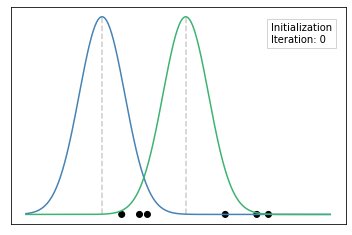

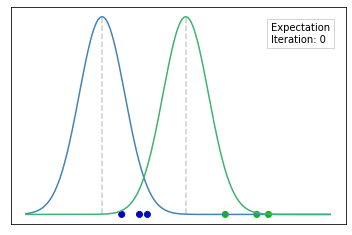

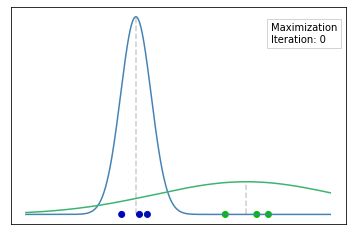

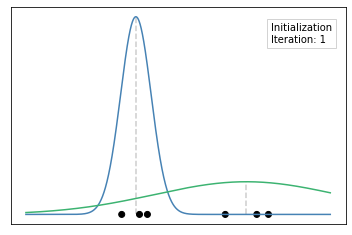

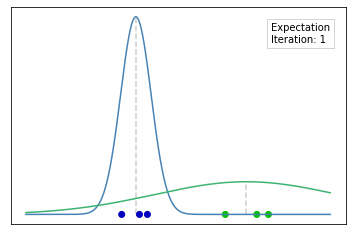

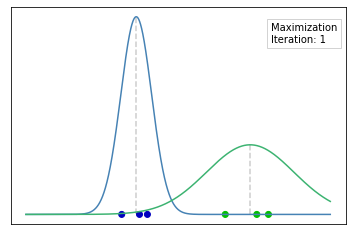

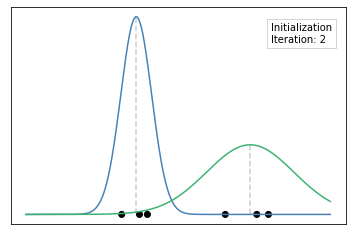

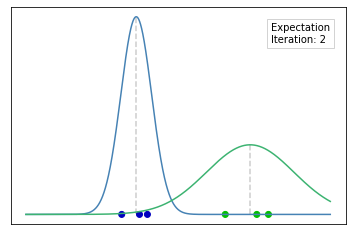

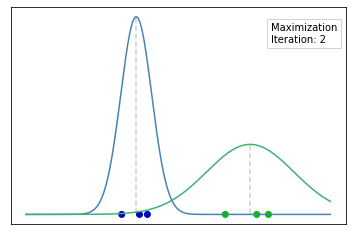

In [140]:
gaussians, mus, sigmas = EM_GMM_1D(Z, n_clusters=2, epsilon=0.001, histo = False, points = True)

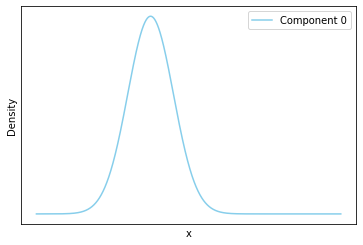

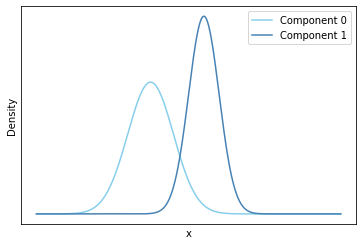

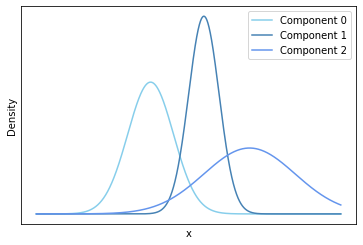

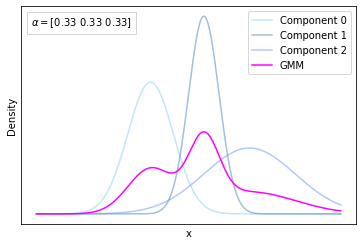

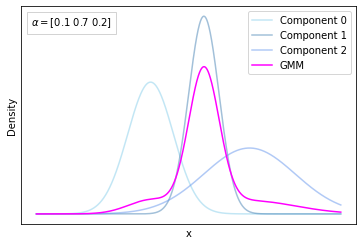

In [11]:
for c in range(len(gs)):
    plot_gmm(gs[0:c+1], alphas=np.array([1/3,1/3,1/3]), plot_GMM = False)
plot_gmm(gs, alphas=np.array([1/3,1/3,1/3]))
plot_gmm(gs, alphas=np.array([1/10,7/10,2/10]))